In [ ]:
# from load import MoEWorker
from tqdm import tqdm
import dei_utils as Dei
import matplotlib.pyplot as plt
import seaborn as sns


model_name_list = ['Mixtral-8x7B-v0.1','Qwen1.5-MoE-A2.7B','DeepSeek-V2-Lite','Moonlight-16B-A3B',]
model_name_list = [
    'Mixtral-8x7B-v0.1','Mixtral-8x7B-Instruct-v0.1','Qwen1.5-MoE-A2.7B',
    'DeepSeek-V2-Lite','DeepSeek-V2-Lite-Chat','Moonlight-16B-A3B','Moonlight-16B-A3B-Instruct',]


In [ ]:
def plot_heatmap(tensor,title=None, save_path=None):
    plt.figure(figsize=(4, 3))
    sns.heatmap(tensor.numpy(), cmap='viridis', 
                vmin=0, vmax=1,
                # , fmt='.2f', annot=True
                )
    if title:
        plt.title(title)
    if save_path:
        plt.savefig(save_path)
    plt.show()

a = Dei.load(f'dist/exp_cos/{model_name_list[0]}')
# for layer in range(1):
for layer in range(32):
    title=f'intra_cos/{model_name_list[0]}/{layer:02d}'
    save_path=f'/new_data/yanghq/data/intra_sim_heatmap/{model_name_list[0]}/{layer:02d}.png'
    plot_heatmap(a[0],title,save_path)
print('a')

In [ ]:
a = Dei.load(f'dist/inter_exp_cos/{model_name_list[0]}')
# for layer in range(1):
for layer in range(31):
    title=f'intra_cos/{model_name_list[0]}/{layer:02d}'
    save_path=f'/new_data/yanghq/data/inter_sim_heatmap/{model_name_list[0]}/{layer:02d}.png'
    plot_heatmap(a[0],title,save_path)
# print('a')

In [1]:
from moe_worker import MoEWorker
from tqdm import tqdm
import dei_utils as Dei
import torch
device='cpu'
device='cuda'


def compute_stable_rank(W):
    # Perform singular value decomposition
    U, S, V = torch.svd(W)
    
    # Calculate stable rank
    sigma_squared = S ** 2  # Square of singular values
    stable_rank = sigma_squared.sum() / sigma_squared.max()
    
    return stable_rank.item()

model_name='/new_data/yanghq/models/mistralai/Mixtral-8x7B-v0.1'
model_name='/new_data/yanghq/data/intra_sim_heatmap/DeepSeek-V2-Lite'
# model_name='/new_data/yanghq/data/intra_sim_heatmap/DeepSeek-V2-Lite-Chat'
# model_name='/new_data/yanghq/data/intra_sim_heatmap/Moonlight-16B-A3B'

# for layer_idx in [0,1,25,26,27,]:

sr_e = torch.zeros([27,64]).to(torch.float).to(device) + 100.0
sr_d = torch.zeros([27,64]).to(torch.float).to(device) - 100.0

for layer_idx in tqdm(range(27)):
# for layer_idx in range(27):
    if layer_idx==0:continue

    worker = MoEWorker(model_name)
    
    num_experts = 16
    
    # print(layer_idx)
    experts = worker.get_expert(layer_idx,False).to(torch.float).to(device)
    # experts = experts[:num_experts,0].clone().to(torch.float).to(device)
    # print(experts.shape)

    delta = [experts[i] - experts[0] for i in range(num_experts)]
    delta = torch.stack(delta)
    delta = delta.to(torch.float).to(device)
    # print(delta.shape)
    
    # for i in tqdm(range(num_experts)):
    for i in range(num_experts):
        sr_e[layer_idx,i] = compute_stable_rank(experts[i])
        sr_d[layer_idx,i] = compute_stable_rank(delta[i])

print(sr_e)
print(sr_d)

100%|██████████| 27/27 [09:06<00:00, 20.22s/it]


tensor([[ 100.0000,  100.0000,  100.0000,  ...,  100.0000,  100.0000,
          100.0000],
        [ 994.5218, 1088.6412,  835.0976,  ...,  100.0000,  100.0000,
          100.0000],
        [ 799.2677, 1131.6219, 1191.6444,  ...,  100.0000,  100.0000,
          100.0000],
        ...,
        [1172.9071, 1040.1254, 1017.1671,  ...,  100.0000,  100.0000,
          100.0000],
        [1160.6545, 1048.9823, 1211.8921,  ...,  100.0000,  100.0000,
          100.0000],
        [1073.5963, 1032.9790,  954.4670,  ...,  100.0000,  100.0000,
          100.0000]], device='cuda:0')
tensor([[-100.0000, -100.0000, -100.0000,  ..., -100.0000, -100.0000,
         -100.0000],
        [      nan, 1097.0950, 1013.5684,  ..., -100.0000, -100.0000,
         -100.0000],
        [      nan, 1115.7662, 1134.5792,  ..., -100.0000, -100.0000,
         -100.0000],
        ...,
        [      nan, 1187.1934, 1185.2490,  ..., -100.0000, -100.0000,
         -100.0000],
        [      nan, 1185.0680, 1199.9481,  ...

In [ ]:
ee = sr_e[0:,1:32].sum(1)/31
dd = sr_d[0:,1:32].sum(1)/31
ee[0]=dd[0]=0
print(ee)
print(dd)

tensor([  0.0000, 498.7516, 552.3267, 557.4084, 553.2305, 568.0480, 563.1060,
        557.9901, 526.8300, 568.1237, 574.6696, 564.0329, 603.6014, 594.9291,
        596.0507, 605.6160, 609.8280, 610.4019, 607.8522, 606.9600, 594.1920,
        604.7818, 590.3409, 597.7873, 554.8875, 550.8901, 534.8242],
       device='cuda:0')
tensor([  0.0000, 453.3844, 473.3442, 517.2829, 497.6657, 510.8220, 504.4016,
        509.2007, 445.7649, 402.2930, 517.2053, 512.3938, 526.1386, 518.5000,
        527.9869, 530.8400, 526.7213, 528.5441, 535.1577, 530.8884, 529.7641,
        452.0287, 517.0269, 515.3601, 513.2305, 508.5895, 498.8617],
       device='cuda:0')


In [20]:
ratio = (dd-ee)/ee
ratio *= 100
# ratio = (1-ratio)*100
print(ratio)

tensor([     nan,  -9.0962, -14.3000,  -7.1986, -10.0437, -10.0741, -10.4251,
         -8.7438, -15.3873, -29.1892,  -9.9995,  -9.1553, -12.8334, -12.8468,
        -11.4191, -12.3471, -13.6279, -13.4105, -11.9592, -12.5332, -10.8429,
        -25.2576, -12.4189, -13.7887,  -7.5073,  -7.6786,  -6.7242],
       device='cuda:0')


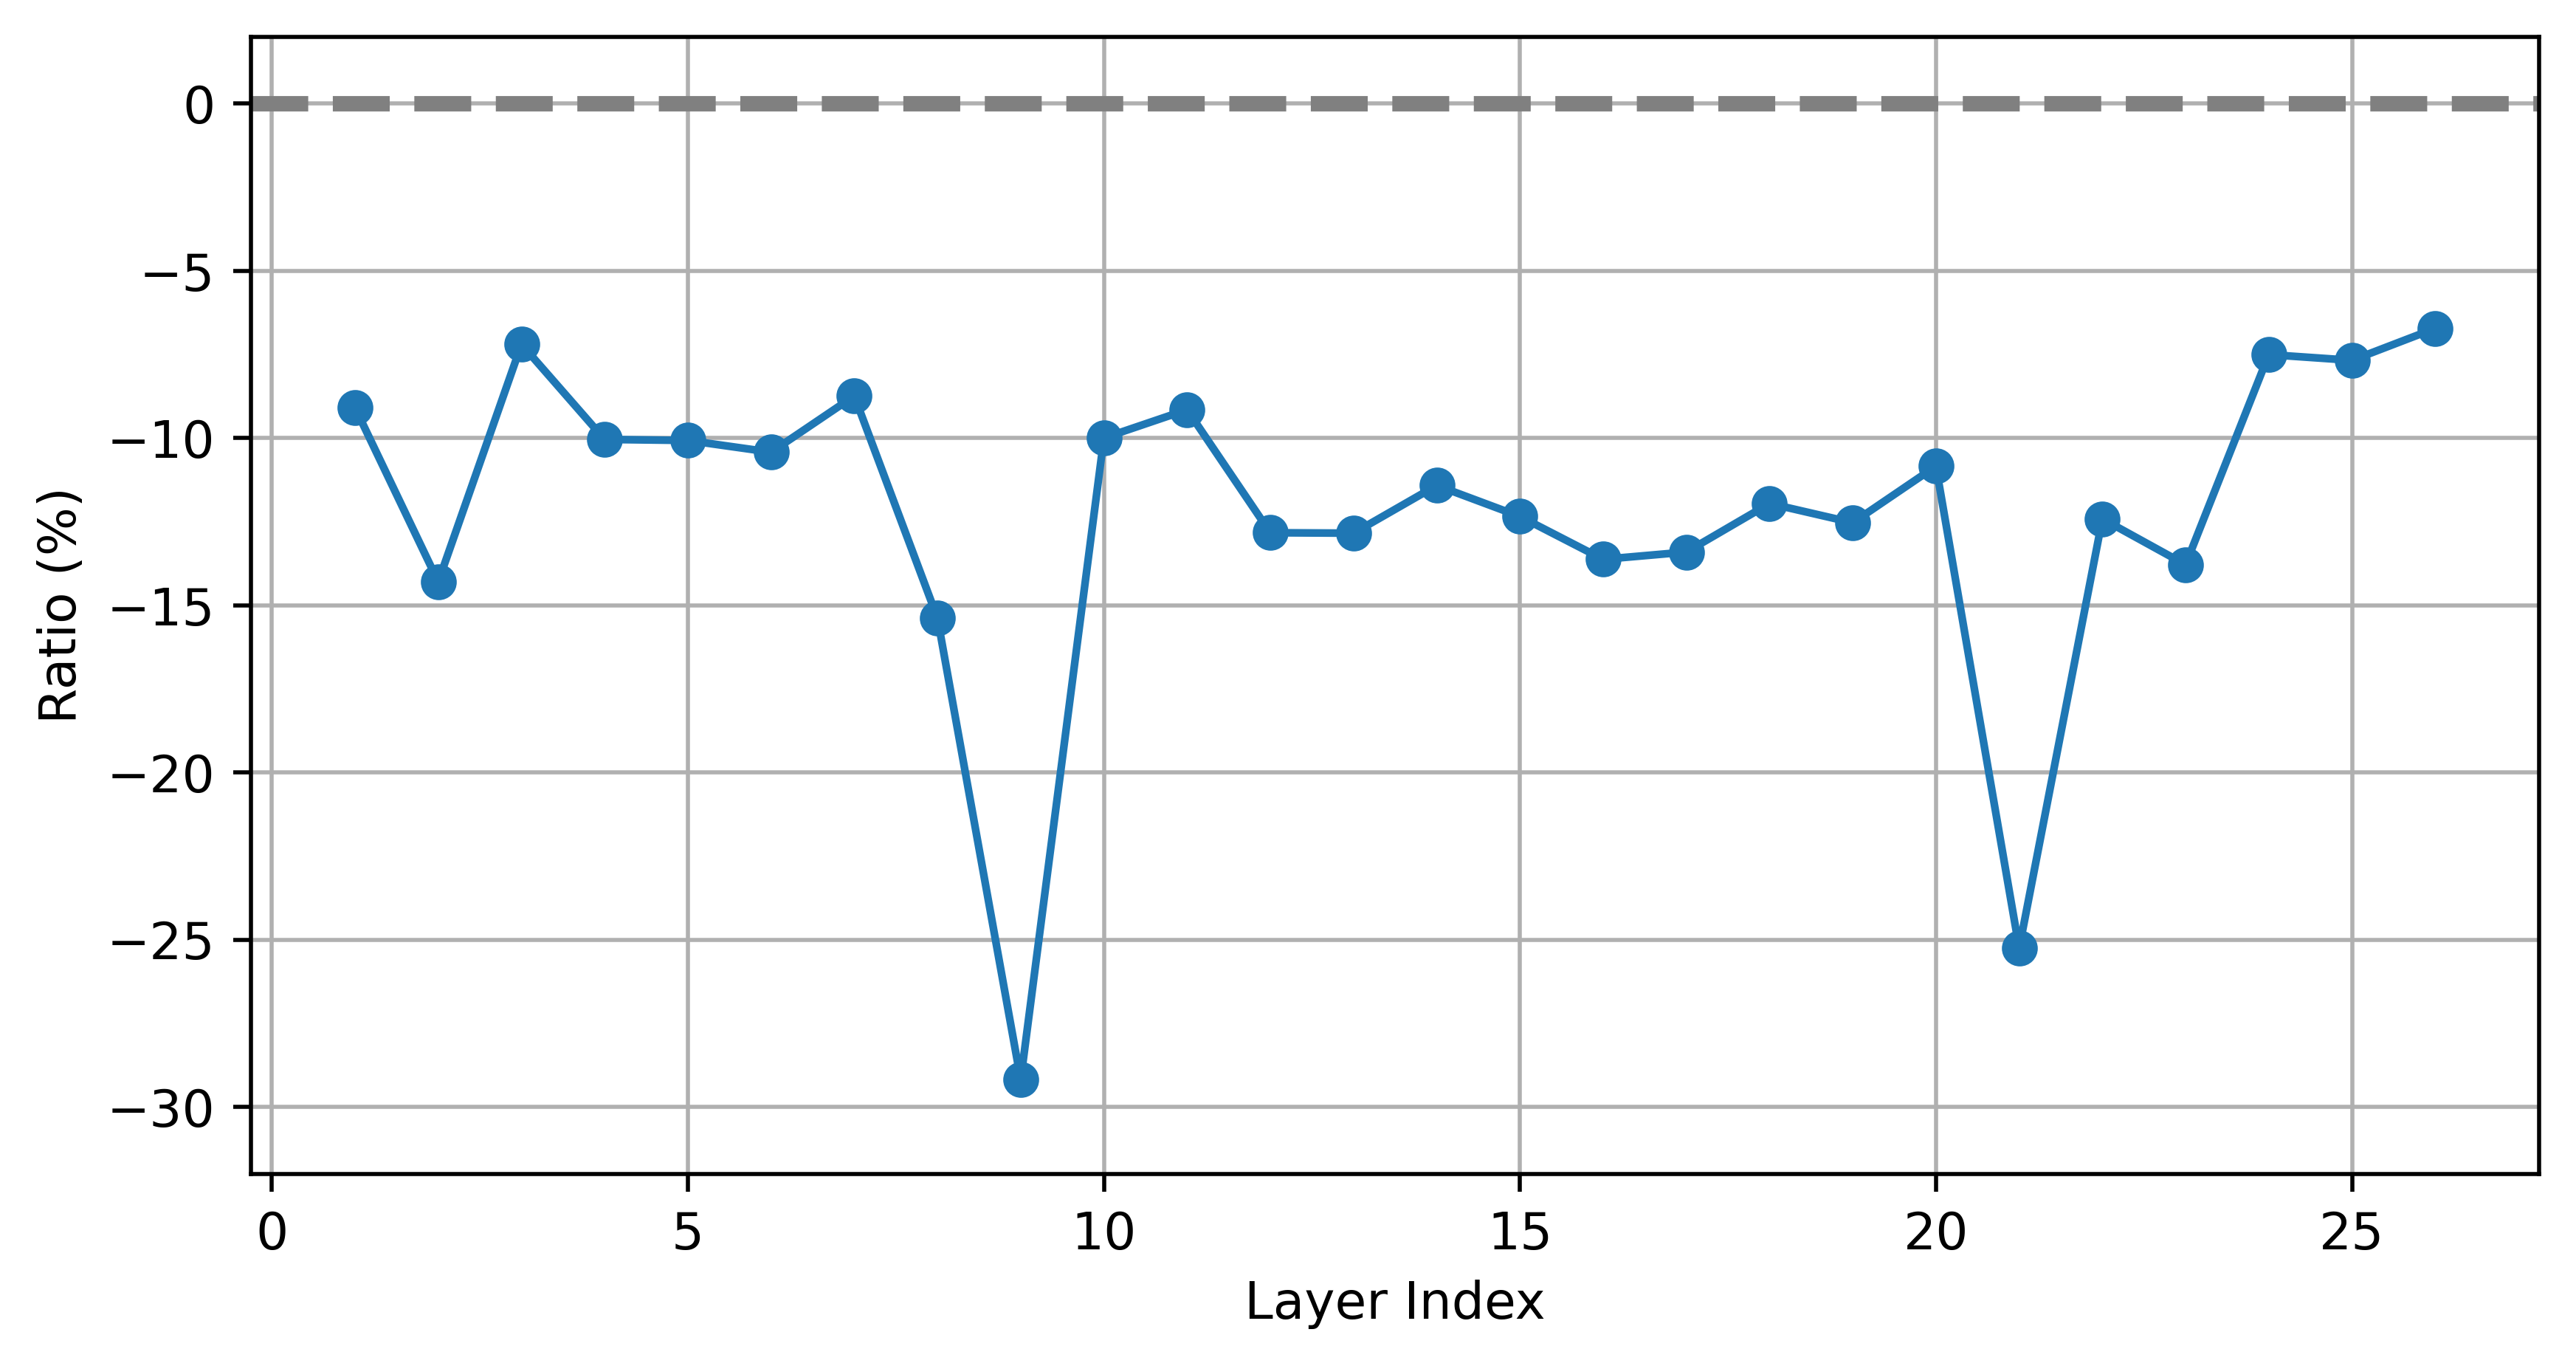

In [31]:
import torch
import matplotlib.pyplot as plt

def plot_tensor_line(tensor):
    """
    画出输入 tensor (一维) 的折线图
    :param tensor: PyTorch 或 TensorFlow 的一维张量
    """
    if isinstance(tensor, torch.Tensor):
        tensor = tensor.detach().cpu().numpy()  # 转换为 NumPy 数组
    elif hasattr(tensor, "numpy"):  # 兼容 TensorFlow 张量
        tensor = tensor.numpy()
    
    plt.figure(figsize=(8, 4),dpi=500)
    plt.plot(range(len(tensor)), tensor,marker='o', linestyle='-')
    plt.xlabel('Layer Index')
    plt.ylabel('Ratio (%)')
    
    plt.ylim(-32, 2)
    plt.axhline(y=0, color='gray', linestyle='--', linewidth=3)
    
    # plt.title('Tensor Line Plot')
    plt.grid(True)
    plt.show()
    plt.close()

# plot_tensor_line(ee)
# plot_tensor_line(dd)
plot_tensor_line(ratio)

In [ ]:
from moe_worker import MoEWorker
from tqdm import tqdm
# import dei_utils as Dei
import torch
device='cpu'
device='cuda'


def compute_stable_rank(W):
    # Perform singular value decomposition
    U, S, V = torch.svd(W)
    
    # Calculate stable rank
    sigma_squared = S ** 2  # Square of singular values
    stable_rank = sigma_squared.sum() / sigma_squared.max()
    
    return stable_rank.item()

model_name='/new_data/yanghq/models/mistralai/Mixtral-8x7B-v0.1'
# model_name='/new_data/yanghq/data/intra_sim_heatmap/DeepSeek-V2-Lite'
# model_name='/new_data/yanghq/data/intra_sim_heatmap/DeepSeek-V2-Lite-Chat'
# model_name='/new_data/yanghq/data/intra_sim_heatmap/Moonlight-16B-A3B'
model_name='/data/yanghq/models/deepseek-ai/DeepSeek-V2-Lite'

# for layer_idx in [0,1,25,26,27,]:

sr_e = torch.zeros([27,64]).to(torch.float).to(device) + 100.0
sr_d = torch.zeros([27,64]).to(torch.float).to(device) - 100.0

for layer_idx in tqdm(range(27)):
# for layer_idx in range(27):
    if layer_idx==0:continue

    worker = MoEWorker(model_name)
    
    num_experts = 16
    
    # print(layer_idx)
    experts = worker.get_expert(layer_idx,False).to(torch.float).to(device)
    # experts = experts[:num_experts,0].clone().to(torch.float).to(device)
    # print(experts.shape)

    delta = [experts[i] - experts[0] for i in range(num_experts)]
    delta = torch.stack(delta)
    delta = delta.to(torch.float).to(device)
    # print(delta.shape)
    
    # for i in tqdm(range(num_experts)):
    for i in range(num_experts):
        sr_e[layer_idx,i] = compute_stable_rank(experts[i])
        sr_d[layer_idx,i] = compute_stable_rank(delta[i])

print(sr_e)
print(sr_d)

: 